## Import libraries

In [1]:
# Import essential libraries for data analysis and visualization
import numpy as np                  
import matplotlib.pylab as plt      
import pandas as pd                 
import awkward as ak                
import uproot                       

import vector                       
vector.register_awkward()           

import requests                     
import os                           
import time                        
import json                         

# Import utility functions from a custom module for handling specific tasks
from geometry import deltar, radial_to_cartesian2d, cartesian_to_radial2d, bound_phi
import dpoa_utilities      
from dpoa_utilities import get_files_for_dataset  
from dpoa_utilities import pretty_print  
from dpoa_utilities import build_lumi_mask  
import glob

## Selecting the data

In [2]:
# Find all .txt files inside ../data/raw
input_files = [file for file in glob.glob("../data/raw/*.txt")]

# List to store all .root file paths
filenames = []

# Read each .txt file and extract the .root file paths
for txt_file in input_files:
    print(f"\n📄 Reading list: {txt_file}")
    with open(txt_file, "r") as file:
        root_files = [line.strip() for line in file.readlines() if line.strip()]
        filenames.extend(root_files)
    dataset_name = os.path.splitext(os.path.basename(txt_file))[0]

# Print all collected .root file paths
print("\nList of all .root files to be processed:")
for fname in filenames:
    print(fname)


📄 Reading list: ../data/raw/FILE_LIST_WJetsToLNu_Pt-250To400.txt

List of all .root files to be processed:
root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/WJetsToLNu_Pt-250To400_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/4C2D7099-87CA-B540-865B-AE25C6929F16.root


In [3]:
# Lists to store the data of all variables
jet_pt, jet_eta, jet_phi, jet_mass = [], [], [], []
jet_btag_csvv2, jet_ch_hef = [], []
muon_iso, muon_tightId, muon_pt, muon_eta, muon_phi, muon_mass, muon_looseId = [], [], [], [], [], [], []
met_pt, met_eta, met_phi, calo_met_pt, met_pt_pf, met_phi_pf = [], [], [], [], [], []
electron_pt, electron_eta, electron_phi, electron_mass = [], [], [], []
tau_pt, tau_eta, tau_phi, tau_mass = [], [], [], []
photon_pt, photon_eta, photon_phi, photon_mass = [], [], [], []
gen_weights, pileup = [], []
HLT_PFMET170_HBHECleaned, HLT_PFMET170_HBHE_BeamHaloCleaned = [], []
HLT_PFMETNoMu120_PFMHTNoMu120_IDTight, HLT_MET75_IsoTrk50 = [], []

# Process each file
for filename in filenames:
    try:
        f = uproot.open(filename)
        if "Events" in f:
            events = f["Events"]

            # Jets
            jet_pt.append(events["Jet_pt"].array())
            jet_eta.append(events["Jet_eta"].array())
            jet_phi.append(events["Jet_phi"].array())
            jet_mass.append(events["Jet_mass"].array())
            jet_btag_csvv2.append(events["Jet_btagCSVV2"].array())
            jet_ch_hef.append(events["Jet_chHEF"].array())

            # Muons
            muon_iso.append(events["Muon_miniIsoId"].array())
            muon_tightId.append(events["Muon_tightId"].array())
            muon_pt.append(events["Muon_pt"].array())
            muon_eta.append(events["Muon_eta"].array())
            muon_phi.append(events["Muon_phi"].array())
            muon_mass.append(events["Muon_mass"].array())
            muon_looseId.append(events["Muon_looseId"].array())

            # MET
            met_pt.append(events["PuppiMET_pt"].array())
            met_phi.append(events["PuppiMET_phi"].array())
            met_eta.append(0*events['PuppiMET_pt'].array())
            calo_met_pt.append(events["CaloMET_pt"].array())
            met_pt_pf.append(events["MET_pt"].array())
            met_phi_pf.append(events["MET_phi"].array())

            # Electrons
            electron_pt.append(events["Electron_pt"].array())
            electron_eta.append(events["Electron_eta"].array())
            electron_phi.append(events["Electron_phi"].array())
            electron_mass.append(events["Electron_mass"].array())

            # Taus
            tau_pt.append(events["Tau_pt"].array())
            tau_eta.append(events["Tau_eta"].array())
            tau_phi.append(events["Tau_phi"].array())
            tau_mass.append(events["Tau_mass"].array())

            # Photons
            photon_pt.append(events["Photon_pt"].array())
            photon_eta.append(events["Photon_eta"].array())
            photon_phi.append(events["Photon_phi"].array())
            photon_mass.append(events["Photon_mass"].array())

            gen_weights.append(events['genWeight'].array())
            pileup.append(events['Pileup_nTrueInt'].array())

            # Triggers of MET 
            HLT_PFMET170_HBHECleaned.append(events['HLT_PFMET170_HBHECleaned'].array())
            HLT_PFMET170_HBHE_BeamHaloCleaned.append(events['HLT_PFMET170_HBHE_BeamHaloCleaned'].array())
            HLT_PFMETNoMu120_PFMHTNoMu120_IDTight.append(events['HLT_PFMETNoMu120_PFMHTNoMu120_IDTight'].array())
            HLT_MET75_IsoTrk50.append(events['HLT_MET75_IsoTrk50'].array())
            
            # Print success when opening the file
            print(f"Successfully processed {filename}")

    except Exception as e:
        print(f"Error processing {filename}: {e}")

# Concatenate all variables in single arrays
jet_pt = ak.concatenate(jet_pt, axis=0)
jet_eta = ak.concatenate(jet_eta, axis=0)
jet_phi = ak.concatenate(jet_phi, axis=0)
jet_mass = ak.concatenate(jet_mass, axis=0)
jet_btag_csvv2 = ak.concatenate(jet_btag_csvv2, axis=0)
jet_ch_hef = ak.concatenate(jet_ch_hef, axis=0)

muon_iso = ak.concatenate(muon_iso, axis=0)
muon_tightId = ak.concatenate(muon_tightId, axis=0)
muon_pt = ak.concatenate(muon_pt, axis=0)
muon_eta = ak.concatenate(muon_eta, axis=0)
muon_phi = ak.concatenate(muon_phi, axis=0)
muon_mass = ak.concatenate(muon_mass, axis=0)
muon_looseId = ak.concatenate(muon_looseId, axis=0)

met_pt = ak.concatenate(met_pt, axis=0)
met_eta = ak.concatenate(met_eta, axis=0)
met_phi = ak.concatenate(met_phi, axis=0)
calo_met_pt = ak.concatenate(calo_met_pt, axis=0)
met_pt_pf = ak.concatenate(met_pt_pf, axis=0)
met_phi_pf = ak.concatenate(met_phi_pf, axis=0)

electron_pt = ak.concatenate(electron_pt, axis=0)
electron_eta = ak.concatenate(electron_eta, axis=0)
electron_phi = ak.concatenate(electron_phi, axis=0)
electron_mass = ak.concatenate(electron_mass, axis=0)

tau_pt = ak.concatenate(tau_pt, axis=0)
tau_eta = ak.concatenate(tau_eta, axis=0)
tau_phi = ak.concatenate(tau_phi, axis=0)
tau_mass = ak.concatenate(tau_mass, axis=0)

photon_pt = ak.concatenate(photon_pt, axis=0)
photon_eta = ak.concatenate(photon_eta, axis=0)
photon_phi = ak.concatenate(photon_phi, axis=0)
photon_mass = ak.concatenate(photon_mass, axis=0)

gen_weights = ak.concatenate(gen_weights, axis=0)
pileup = ak.concatenate(pileup, axis=0)

HLT_PFMET170_HBHECleaned = ak.concatenate(HLT_PFMET170_HBHECleaned, axis=0) 
HLT_PFMET170_HBHE_BeamHaloCleaned = ak.concatenate(HLT_PFMET170_HBHE_BeamHaloCleaned, axis=0)
HLT_PFMETNoMu120_PFMHTNoMu120_IDTight = ak.concatenate(HLT_PFMETNoMu120_PFMHTNoMu120_IDTight, axis=0)
HLT_MET75_IsoTrk50 = ak.concatenate(HLT_MET75_IsoTrk50, axis=0)

Successfully processed root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/WJetsToLNu_Pt-250To400_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/4C2D7099-87CA-B540-865B-AE25C6929F16.root


In [4]:
pretty_print(events.keys(), fmt='40s', require=['HLT_PFMET170'])

HLT_PFMET170_NotCleaned                  HLT_PFMET170_NoiseCleaned                
HLT_PFMET170_HBHECleaned                 HLT_PFMET170_JetIdCleaned                
HLT_PFMET170_BeamHaloCleaned             HLT_PFMET170_HBHE_BeamHaloCleaned        


In [5]:
pretty_print(events.keys(), fmt='40s', require=['HLT_PFMETNoMu'])

HLT_PFMETNoMu90_PFMHTNoMu90_IDTight      HLT_PFMETNoMu100_PFMHTNoMu100_IDTight    
HLT_PFMETNoMu110_PFMHTNoMu110_IDTight    HLT_PFMETNoMu120_PFMHTNoMu120_IDTight    


## Extract some data

In [6]:
# Decompose MET into x and y components
met_px = met_pt * np.cos(met_phi)
met_py = met_pt * np.sin(met_phi)

# Decompose the transverse momentum (pT) of muons, electrons, and taus into x and y components
muon_px = muon_pt * np.cos(muon_phi)
muon_py = muon_pt * np.sin(muon_phi)

electron_px = electron_pt * np.cos(electron_phi)
electron_py = electron_pt * np.sin(electron_phi)

tau_px = tau_pt * np.cos(tau_phi)
tau_py = tau_pt * np.sin(tau_phi)

# Combine all px and py components using ak.concatenate
combined_px = ak.concatenate([muon_px, electron_px, tau_px], axis=1)
combined_py = ak.concatenate([muon_py, electron_py, tau_py], axis=1)

# Sum the x and y components to calculate the recoil vector U
recoil_px = met_px + ak.sum(combined_px, axis=1)
recoil_py = met_py + ak.sum(combined_py, axis=1)

# Create a structured array representing the recoil vector U with x and y components
recoil_vector_u = ak.zip({"px": recoil_px, "py": recoil_py})

# Calculate the magnitude of the recoil vector U
recoil_magnitude_u = np.sqrt(recoil_px**2 + recoil_py**2)

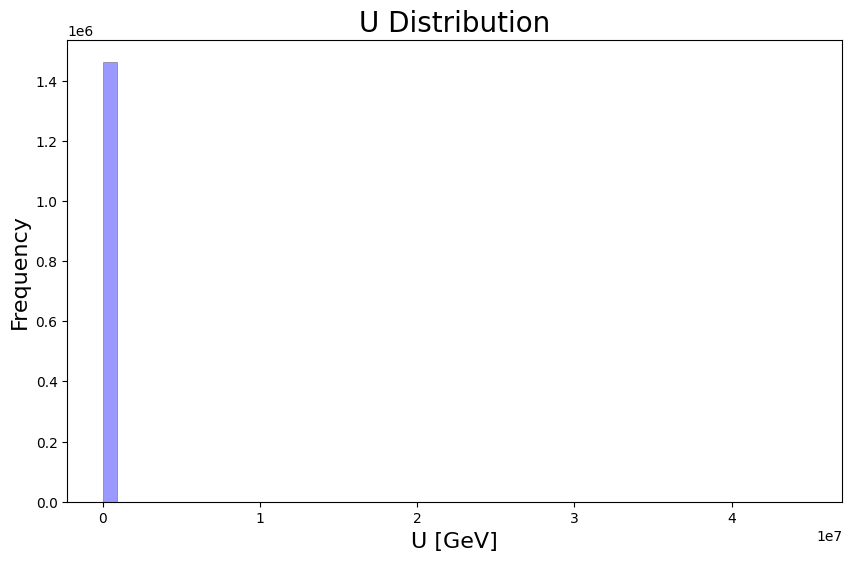

In [7]:
# Create the U histogram 
plt.figure(figsize=(10, 6))
plt.hist(recoil_magnitude_u, bins=50, color='blue', alpha=0.4, edgecolor='black', linewidth=0.5, histtype='stepfilled')
plt.title('U Distribution', fontsize=20)  
plt.xlabel('U [GeV]', fontsize=16)  
plt.ylabel('Frequency', fontsize=16)  
plt.grid(False)
plt.show()

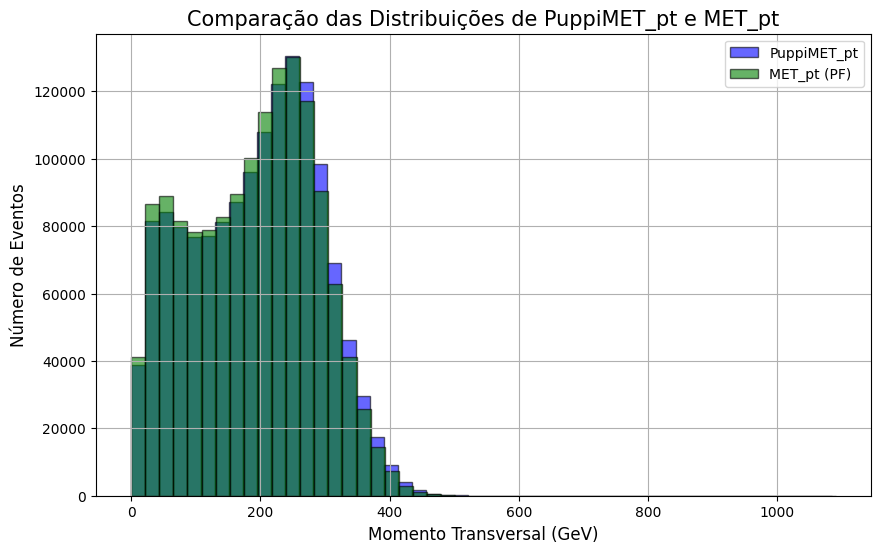

In [8]:
plt.figure(figsize=(10,6))

plt.hist(met_pt, bins=50, color='blue', alpha=0.6, label='PuppiMET_pt', edgecolor='black')

plt.hist(met_pt_pf, bins=50, color='green', alpha=0.6, label='MET_pt (PF)', edgecolor='black')

plt.title('Comparação das Distribuições de PuppiMET_pt e MET_pt', fontsize=15)
plt.xlabel('Momento Transversal (GeV)', fontsize=12)
plt.ylabel('Número de Eventos', fontsize=12)

plt.legend()

plt.grid(True)
plt.show()

Integral of PuppiMET_pt: 1462591.0
Integral of MET_pt (PF): 1462591.0


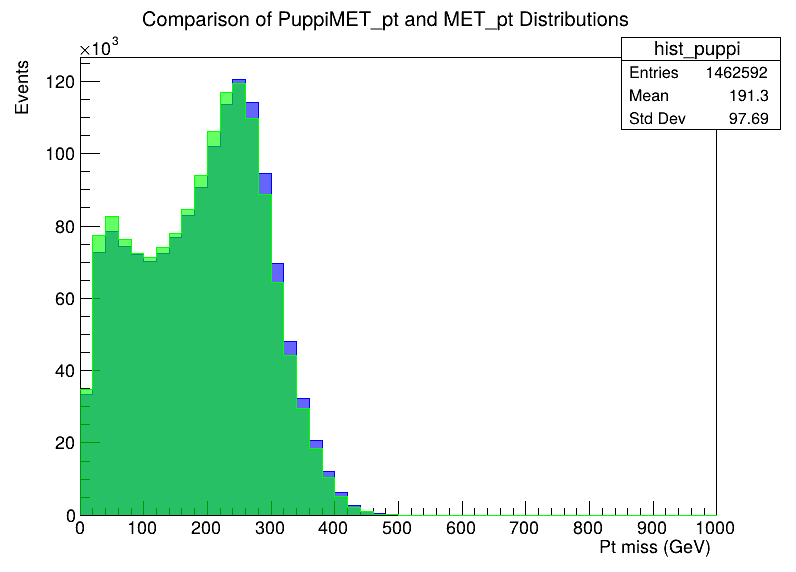

In [9]:
import ROOT

hist_puppi = ROOT.TH1F("hist_puppi", "PuppiMET_pt", 50, 0, 1000)
hist_pf = ROOT.TH1F("hist_pf", "MET_pt (PF)", 50, 0, 1000)

for value in met_pt:
    hist_puppi.Fill(value)

for value in met_pt_pf:
    hist_pf.Fill(value)

integral_puppi = hist_puppi.Integral()
integral_pf = hist_pf.Integral()

print(f"Integral of PuppiMET_pt: {integral_puppi}")
print(f"Integral of MET_pt (PF): {integral_pf}")

hist_puppi.SetLineColor(ROOT.kBlue)
hist_puppi.SetFillColorAlpha(ROOT.kBlue, 0.6)
hist_pf.SetLineColor(ROOT.kGreen)
hist_pf.SetFillColorAlpha(ROOT.kGreen, 0.6)

c = ROOT.TCanvas("c", "PuppiMET_pt and MET_pt", 800, 600)

hist_puppi.Draw("HIST")
hist_pf.Draw("HIST SAME")

hist_puppi.SetTitle("Comparison of PuppiMET_pt and MET_pt Distributions")
hist_puppi.GetXaxis().SetTitle("Pt miss (GeV)")
hist_puppi.GetYaxis().SetTitle("Events")

# Mostrar o gráfico
c.Draw()

## Selections

The Baseline Cut:
1. U > 200 GeV  
3. (|Pt miss Calo - U| / U) < 0.5
4. Lead Jet: Pt > 200 GeV and |eta| < 2.4 and 0.1 < Ch. Had. EF < 0.95   
5. Veto Jets: Pt Jet > 40 GeV and Jet |eta| > 2.4   
6. Veto Photon: Pt > 25 GeV and |eta| < 2.5   
7. Medium CSVv2 b-jet veto: Pt > 40 GeV and |eta| < 2.4

The cuts for the Jets + Pt miss region:
Baseline Cut +
1. Veto Muon: Pt  > 10 GeV and |eta| < 2.5
2. Veto Electron: Pt > 10 GeV and |eta| < 2.5 
3. Veto tau: Pt > 20 GeV and |eta| < 2.3  
4. Δϕ(j1, j2, j3, j4, U) > 0.5

In [10]:
# Lists to store the variables of events that have passed through the cuts
selected_jet_pt = []
selected_jet_eta = []
selected_jet_phi = []
selected_jet_mass = []
selected_jet_btag_csvv2 = []
selected_jet_ch_hef = []

selected_muon_pt = []
selected_muon_eta = []
selected_muon_phi = []
selected_muon_mass = []

selected_met_pt = []
selected_met_phi = []
selected_met_eta = []

selected_calo_met_pt = []

selected_met_pt_pf = []
selected_met_phi_pf = []

selected_recoil_magnitude_u = []

selected_electron_pt = []
selected_electron_eta = []
selected_electron_phi = []
selected_electron_mass = []

selected_tau_pt = []
selected_tau_eta = []
selected_tau_phi = []
selected_tau_mass = []

selected_photon_pt = []
selected_photon_eta = []
selected_photon_phi = []
selected_photon_mass = []

selected_lead_jet_pt = []
selected_lead_jet_eta = []
selected_lead_jet_phi = []
selected_lead_jet_mass = []
selected_lead_jet_btag_csvv2 = []
selected_lead_jet_ch_hef = []

selected_lead_jet2_pt = []
selected_lead_jet2_eta = []
selected_lead_jet2_phi = []
selected_lead_jet2_mass = []
selected_lead_jet2_btag_csvv2 = []
selected_lead_jet2_ch_hef = []

selected_lead_jet3_pt = []
selected_lead_jet3_eta = []
selected_lead_jet3_phi = []
selected_lead_jet3_mass = []
selected_lead_jet3_btag_csvv2 = []
selected_lead_jet3_ch_hef = []

selected_lead_jet4_pt = []
selected_lead_jet4_eta = []
selected_lead_jet4_phi = []
selected_lead_jet4_mass = []
selected_lead_jet4_btag_csvv2 = []
selected_lead_jet4_ch_hef = []

gen_weights_selected = []
pileup_selected = []

In [11]:
# Calculate the number of jets for all events before the loop
num_jets = ak.num(jet_pt, axis=1)  

#Define the threshold for btag
medium_btag_threshold = 0.8

mask_lumi = build_lumi_mask('Cert_278820-284044_13TeV_Legacy2016_Collisions16GH_JSON.txt', events)

In [12]:
# Define the processing function
def process_file(dataset='default', IS_DATA=False):
    """
    Function to process data or Monte Carlo files.
    Parameters:
    - dataset: Name of the dataset (string)
    - IS_DATA: Boolean indicating if the input is real data (True) or Monte Carlo (False)
    """
    
    # Initialize event counters
    total_events = 0
    events_after_cuts = 0
    events_passed_trigger = 0
    events_passed_recoil_magnitude_u = 0
    events_passed_calo_met = 0
    events_passed_num_jets = 0
    events_passed_lead_jet = 0
    
    veto_photon = 0
    veto_bjet = 0
    veto_jet = 0
    veto_muon = 0
    veto_electron = 0
    veto_tau = 0
    events_passed_delta_phi = 0 

    # Iterate over the events and apply cuts one by one
    for i in range(len(recoil_magnitude_u)):
        total_events += 1  

        # Select events that pass MET triggers
        if not (HLT_PFMET170_HBHECleaned[i] or 
                HLT_PFMET170_HBHE_BeamHaloCleaned[i] or
                HLT_PFMETNoMu120_PFMHTNoMu120_IDTight[i] or 
                HLT_MET75_IsoTrk50[i]):
            continue 
        events_passed_trigger += 1

        # Cuts: Baseline 
        if recoil_magnitude_u[i] > 200:
            events_passed_recoil_magnitude_u += 1
        else:
            continue

        if (abs(calo_met_pt[i] - recoil_magnitude_u[i]) / recoil_magnitude_u[i]) < 0.5:
            events_passed_calo_met += 1
        else:
            continue

        if num_jets[i] >= 4:  
            # Get the jets and sort them by pt
            jets_sorted_indices = ak.argsort(jet_pt[i], ascending=False)  
            jets_sorted = jet_pt[i][jets_sorted_indices]  
            eta_sorted = jet_eta[i][jets_sorted_indices]  
            phi_sorted = jet_phi[i][jets_sorted_indices]  
            mass_sorted = jet_mass[i][jets_sorted_indices]  
            ch_hef_sorted = jet_ch_hef[i][jets_sorted_indices]  
            btag_sorted = jet_btag_csvv2[i][jets_sorted_indices]  
            
            # Lead jet cut
            lead_jet_pt = jets_sorted[0]
            lead_jet_eta = eta_sorted[0]
            lead_jet_ch_hef = ch_hef_sorted[0]
            
            events_passed_num_jets += 1
            
        else:
            continue

        if (lead_jet_pt > 200 and abs(lead_jet_eta) < 2.4 and 0.1 < lead_jet_ch_hef < 0.95):
            events_passed_lead_jet += 1
        else:
            continue

        # Veto cuts
        if ak.any(photon_pt[i] > 25) and ak.any(abs(photon_eta[i]) < 2.5):
            continue  
        else:
            veto_photon += 1

        if ak.any(jets_sorted > 40) and ak.any(abs(eta_sorted) < 2.4) and ak.any(btag_sorted > medium_btag_threshold):
            continue  
        else:
            veto_bjet += 1

       
        if ak.any(jets_sorted > 40) and ak.any(abs(eta_sorted) > 2.4):
            continue  
        else:
            veto_jet += 1

        # Cuts: Jets + pt miss region

        # Veto cuts
        if ak.any((muon_pt[i] > 10) & (abs(muon_eta[i]) < 2.5) & muon_looseId[i]):
            continue  
        else:
            veto_muon += 1

       
        if ak.any(electron_pt[i] > 10) and ak.any(abs(electron_eta[i]) < 2.5):
            continue  
        else:
            veto_electron += 1

      
        if ak.any(tau_pt[i] > 20) and ak.any(abs(tau_eta[i]) < 2.3):
            continue  
        else:
            veto_tau += 1

        # Cut: Δϕ(j1,2,3,4, pTmiss) > 0.5 
        delta_phi_jet1 = abs(bound_phi(phi_sorted[0] - recoil_magnitude_u[i]))
        delta_phi_jet2 = abs(bound_phi(phi_sorted[1] - recoil_magnitude_u[i]))
        delta_phi_jet3 = abs(bound_phi(phi_sorted[2] - recoil_magnitude_u[i]))
        delta_phi_jet4 = abs(bound_phi(phi_sorted[3] - recoil_magnitude_u[i]))

        if (delta_phi_jet1 > 0.5 and delta_phi_jet2 > 0.5 and delta_phi_jet3 > 0.5 and delta_phi_jet4 > 0.5):
            events_passed_delta_phi += 1
        else: 
            continue
                            
        events_after_cuts += 1
                            
        if not IS_DATA:
            gen_weights_selected.append(gen_weights[i])
            pileup_selected.append(pileup[i])
                           
        for j in range(len(jets_sorted)):  
            selected_jet_pt.append(jets_sorted[j])
            selected_jet_eta.append(eta_sorted[j])
            selected_jet_phi.append(phi_sorted[j])
            selected_jet_mass.append(mass_sorted[j])
            selected_jet_btag_csvv2.append(btag_sorted[j])
            selected_jet_ch_hef.append(ch_hef_sorted[j])

        selected_muon_pt.append(muon_pt[i])
        selected_muon_eta.append(muon_eta[i])
        selected_muon_phi.append(muon_phi[i])
        selected_muon_mass.append(muon_mass[i])

        selected_met_pt.append(met_pt[i])
        selected_met_phi.append(met_phi[i])
        selected_met_eta.append(met_eta[i])  

        selected_calo_met_pt.append(calo_met_pt[i])

        selected_met_pt_pf.append(met_pt_pf[i])
        selected_met_phi_pf.append(met_phi_pf[i])

        selected_recoil_magnitude_u.append(recoil_magnitude_u[i])

        selected_electron_pt.append(electron_pt[i])
        selected_electron_eta.append(electron_eta[i])
        selected_electron_phi.append(electron_phi[i])
        selected_electron_mass.append(electron_mass[i])

        selected_tau_pt.append(tau_pt[i])
        selected_tau_eta.append(tau_eta[i])
        selected_tau_phi.append(tau_phi[i])
        selected_tau_mass.append(tau_mass[i])

        selected_photon_pt.append(photon_pt[i])
        selected_photon_eta.append(photon_eta[i])
        selected_photon_phi.append(photon_phi[i])
        selected_photon_mass.append(photon_mass[i])

        selected_lead_jet_pt.append(jets_sorted[0])
        selected_lead_jet_eta.append(eta_sorted[0])
        selected_lead_jet_phi.append(phi_sorted[0])
        selected_lead_jet_mass.append(mass_sorted[0])
        selected_lead_jet_btag_csvv2.append(btag_sorted[0])
        selected_lead_jet_ch_hef.append(ch_hef_sorted[0])

        selected_lead_jet2_pt.append(jets_sorted[1])
        selected_lead_jet2_eta.append(eta_sorted[1])
        selected_lead_jet2_phi.append(phi_sorted[1])
        selected_lead_jet2_mass.append(mass_sorted[1])
        selected_lead_jet2_btag_csvv2.append(btag_sorted[1])
        selected_lead_jet2_ch_hef.append(ch_hef_sorted[1])

        selected_lead_jet3_pt.append(jets_sorted[2])
        selected_lead_jet3_eta.append(eta_sorted[2])
        selected_lead_jet3_phi.append(phi_sorted[2])
        selected_lead_jet3_mass.append(mass_sorted[2])
        selected_lead_jet3_btag_csvv2.append(btag_sorted[2])
        selected_lead_jet3_ch_hef.append(ch_hef_sorted[2])

        selected_lead_jet4_pt.append(jets_sorted[3])
        selected_lead_jet4_eta.append(eta_sorted[3])
        selected_lead_jet4_phi.append(phi_sorted[3])
        selected_lead_jet4_mass.append(mass_sorted[3])
        selected_lead_jet4_btag_csvv2.append(btag_sorted[3])
        selected_lead_jet4_ch_hef.append(ch_hef_sorted[3])

    print(f"Processing summary:")
    print(f"Total events processed: {total_events}")
    print(f"Events after trigger selection: {events_passed_trigger}")
    print(f"Events after recoil magnitude U cut: {events_passed_recoil_magnitude_u}")
    print(f"Events after |calo_MET - U| / U < 0.5 cut: {events_passed_calo_met}")
    print(f"Events after number of jets cut: {events_passed_num_jets}")
    print(f"Events after lead jet cut: {events_passed_lead_jet}")
    print(f"Events after photon veto: {veto_photon}")
    print(f"Events after bjet veto: {veto_bjet}")
    print(f"Events after jet veto: {veto_jet}")
    print(f"Events after muon veto: {veto_muon}")
    print(f"Events after electron veto: {veto_electron}")
    print(f"Events after tau veto: {veto_tau}")
    print(f"Events after Δϕ(j1,2,3,4, U) > 0.5 cut: {events_passed_delta_phi}")
    print(f"Events after all cuts: {events_after_cuts}")

In [13]:
#Calling the process_file function with the chosen name
process_file(dataset=dataset_name, IS_DATA=False)

Processing summary:
Total events processed: 1462592
Events after trigger selection: 1130224
Events after recoil magnitude U cut: 1019255
Events after |calo_MET - U| / U < 0.5 cut: 575767
Events after number of jets cut: 455779
Events after lead jet cut: 348883
Events after photon veto: 190581
Events after bjet veto: 166407
Events after jet veto: 35877
Events after muon veto: 21564
Events after electron veto: 14331
Events after tau veto: 8162
Events after Δϕ(j1,2,3,4, U) > 0.5 cut: 8162
Events after all cuts: 8162


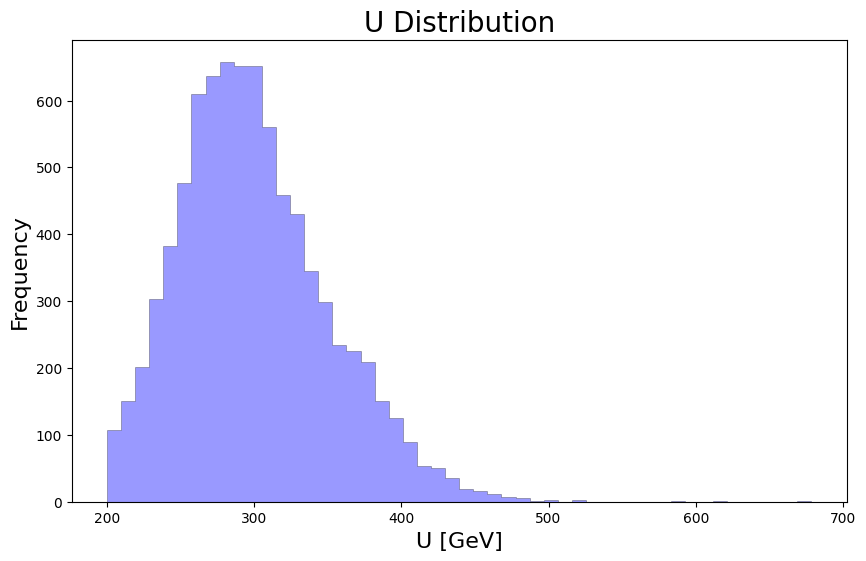

In [14]:
# Create the U histogram 
plt.figure(figsize=(10, 6))
plt.hist(selected_recoil_magnitude_u, bins=50, color='blue', alpha=0.4, edgecolor='black', linewidth=0.5, histtype='stepfilled')
plt.title('U Distribution', fontsize=20)  
plt.xlabel('U [GeV]', fontsize=16)  
plt.ylabel('Frequency', fontsize=16)  
plt.grid(False)
plt.show()

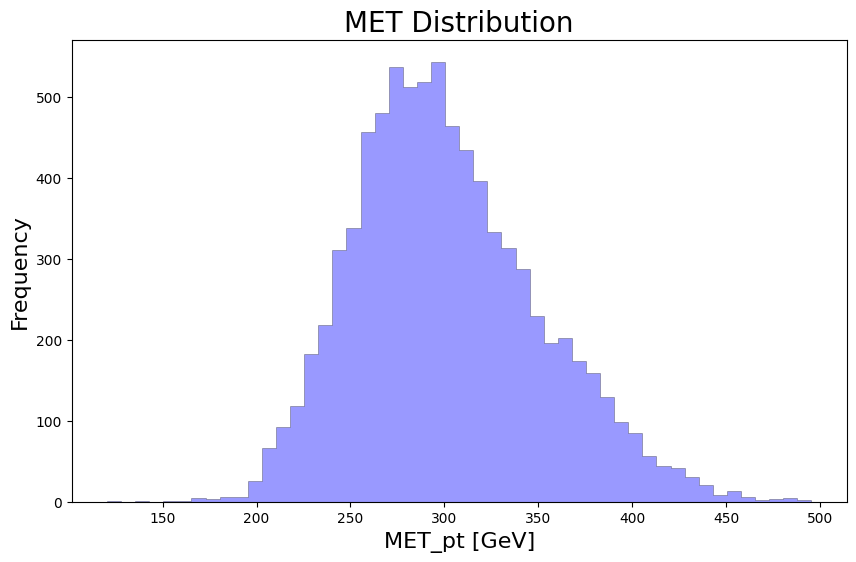

In [15]:
# Create the MET histogram 
plt.figure(figsize=(10, 6))
plt.hist(selected_met_pt, bins=50, color='blue', alpha=0.4, edgecolor='black', linewidth=0.5, histtype='stepfilled')
plt.title('MET Distribution', fontsize=20)  
plt.xlabel('MET_pt [GeV]', fontsize=16)  
plt.ylabel('Frequency', fontsize=16)  
plt.grid(False)
plt.show()

Integral of the histogram: 8161.0


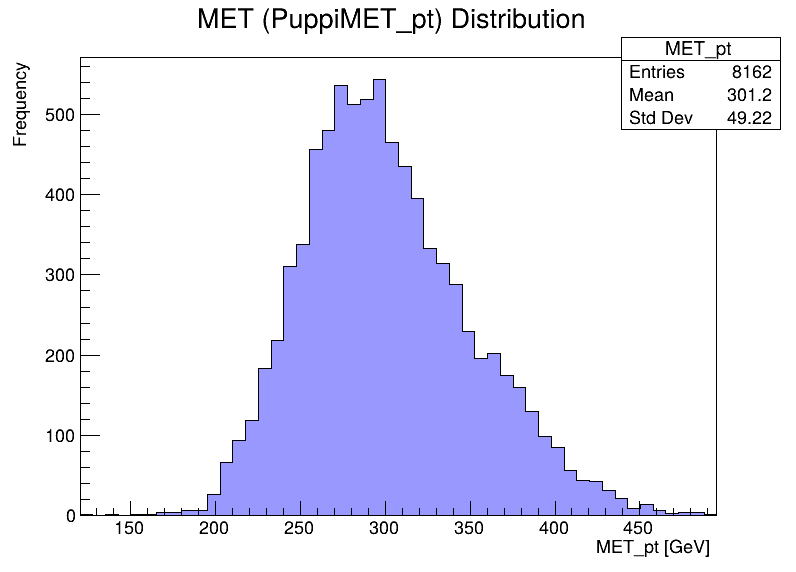

In [16]:
n_bins = 50
min_value = min(selected_met_pt)
max_value = max(selected_met_pt)
hist = ROOT.TH1F("MET_pt", "MET (PuppiMET_pt) Distribution", n_bins, min_value, max_value)

for value in selected_met_pt:
    hist.Fill(value)

canvas = ROOT.TCanvas("canvas", "MET Distribution", 800, 600)

hist.SetFillColorAlpha(ROOT.kBlue, 0.4) 
hist.SetLineColor(ROOT.kBlack) 
hist.SetTitle("MET (PuppiMET_pt) Distribution")
hist.GetXaxis().SetTitle("MET_pt [GeV]")
hist.GetYaxis().SetTitle("Frequency")
hist.Draw("HIST")

integral = hist.Integral()
print(f"Integral of the histogram: {integral}")

canvas.Draw()

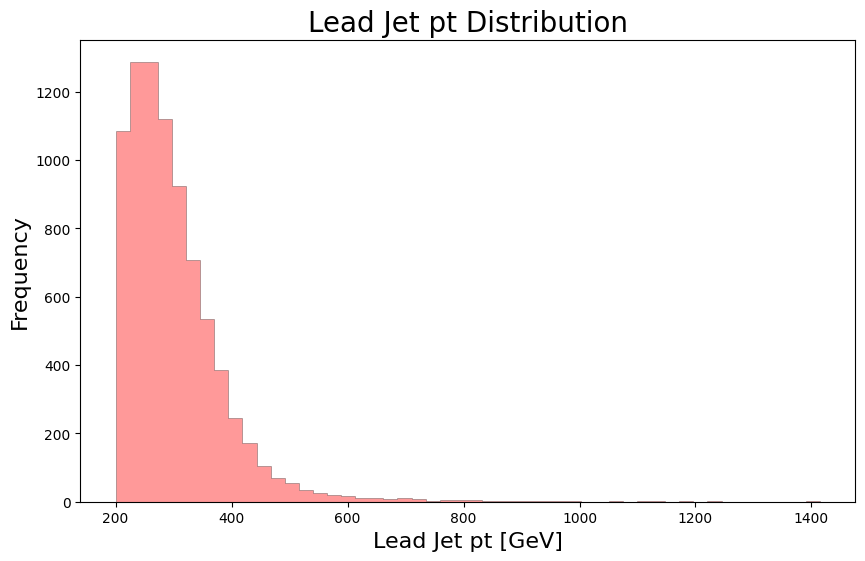

In [17]:
# Create the Lead Jet pt histogram
plt.figure(figsize=(10, 6))
plt.hist(selected_lead_jet_pt, bins=50, color='red', alpha=0.4, edgecolor='black', linewidth=0.5, histtype='stepfilled')
plt.title('Lead Jet pt Distribution', fontsize=20)  
plt.xlabel('Lead Jet pt [GeV]', fontsize=16)  
plt.ylabel('Frequency', fontsize=16)  
plt.grid(False)
plt.show()

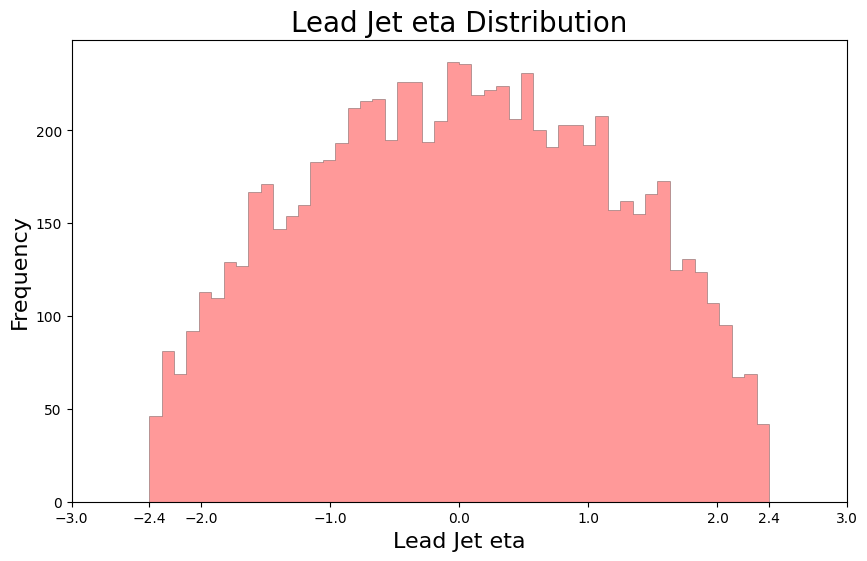

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(selected_lead_jet_eta, bins=50, color='red', alpha=0.4, edgecolor='black', linewidth=0.5, histtype='stepfilled')  
plt.xticks(list(plt.xticks()[0]) + [-2.4, 2.4])
plt.title('Lead Jet eta Distribution', fontsize=20)  
plt.xlabel('Lead Jet eta', fontsize=16)  
plt.ylabel('Frequency', fontsize=16)  
plt.grid(False)
plt.show()

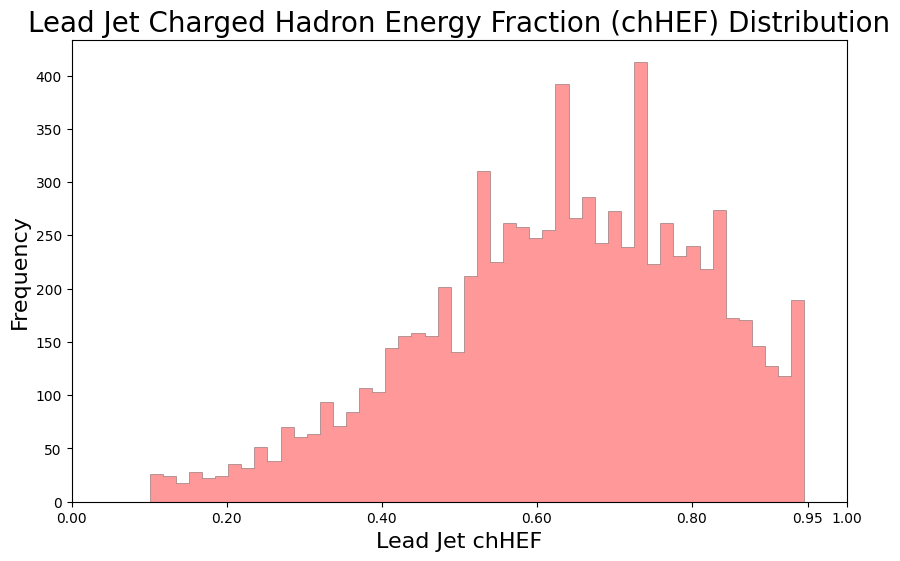

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(selected_lead_jet_ch_hef, bins=50, color='red', alpha=0.4, edgecolor='black', linewidth=0.5, histtype='stepfilled')
plt.xticks(list(plt.xticks()[0]) + [0.95])
plt.title('Lead Jet Charged Hadron Energy Fraction (chHEF) Distribution', fontsize=20)  
plt.xlabel('Lead Jet chHEF', fontsize=16)  
plt.ylabel('Frequency', fontsize=16)  
plt.grid(False)
plt.show()

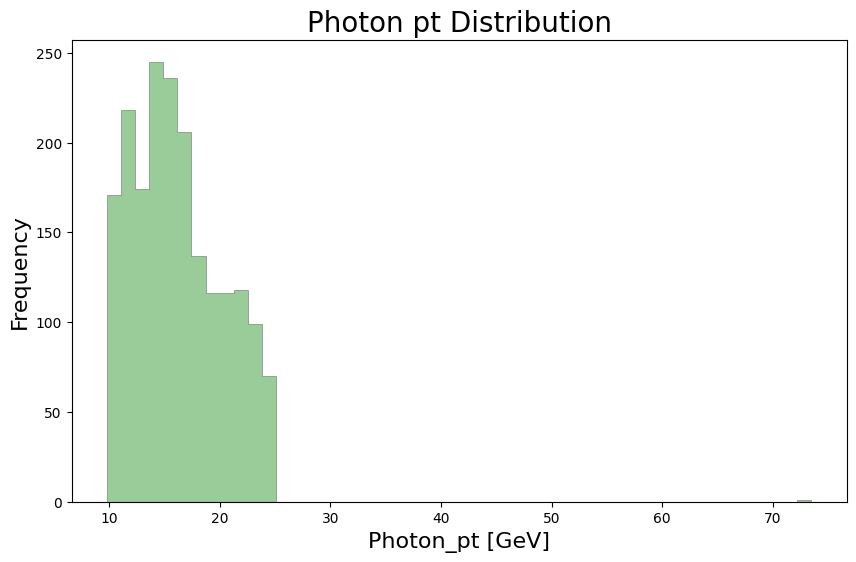

In [20]:
flatten_selected_photon_pt = np.hstack(selected_photon_pt)
plt.figure(figsize=(10,6))
plt.hist(flatten_selected_photon_pt, bins=50, color='green', alpha=0.4, edgecolor='black',linewidth=0.5, histtype='stepfilled')
plt.title('Photon pt Distribution', fontsize=20)
plt.xlabel('Photon_pt [GeV]', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.grid(False)
plt.show()

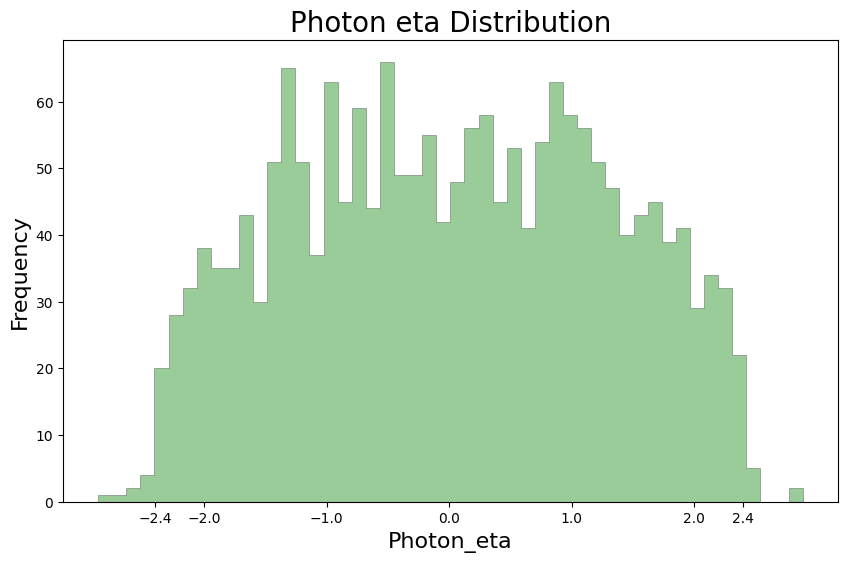

In [21]:
flatten_selected_photon_eta = np.hstack(selected_photon_eta)
plt.figure(figsize=(10,6))
plt.hist(flatten_selected_photon_eta, bins=50, color='green', alpha=0.4, edgecolor='black', linewidth=0.5, histtype='stepfilled')
plt.title('Photon eta Distribution', fontsize=20)
plt.xlabel('Photon_eta', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.grid(False)
plt.xticks([-2.4, -2, -1, 0, 1, 2, 2.4]) 
plt.show()

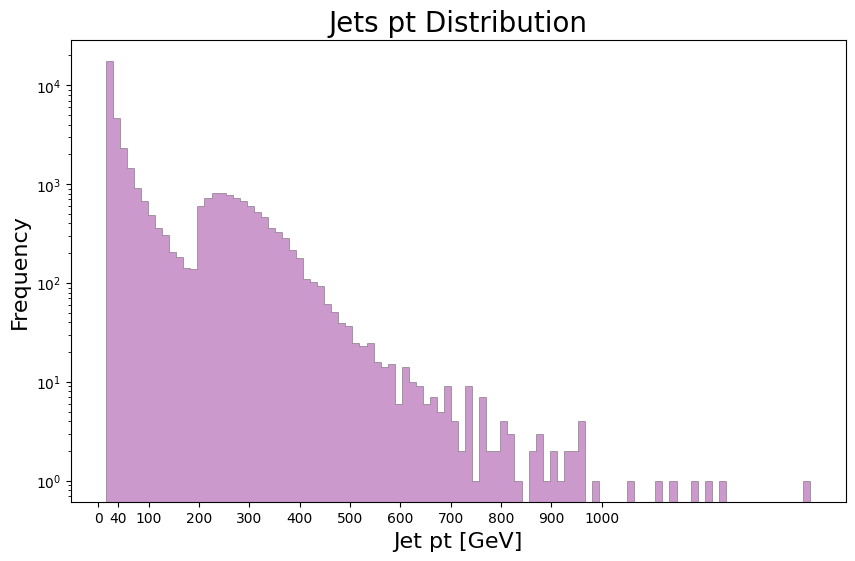

In [22]:
plt.figure(figsize=(10,6))
plt.hist(selected_jet_pt, bins=100, color='purple', alpha=0.4, edgecolor='black', linewidth=0.5, histtype='stepfilled')
plt.xticks([0, 40, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])  
plt.yscale('log')
plt.title('Jets pt Distribution', fontsize=20)
plt.xlabel('Jet pt [GeV]', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.grid(False)
plt.show()

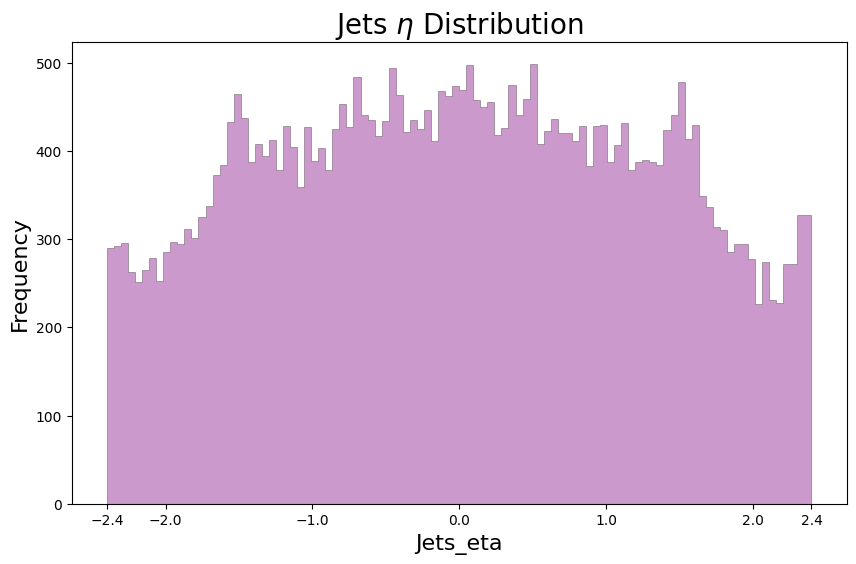

In [23]:
plt.figure(figsize=(10,6))
plt.hist(selected_jet_eta, bins=100, color='purple', alpha=0.4, edgecolor='black', linewidth=0.5, histtype='stepfilled')
plt.xticks([-2.4, -2, -1, 0, 1, 2, 2.4])  
plt.title('Jets $\eta$ Distribution', fontsize=20)
plt.xlabel('Jets_eta', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.grid(False)
plt.show()

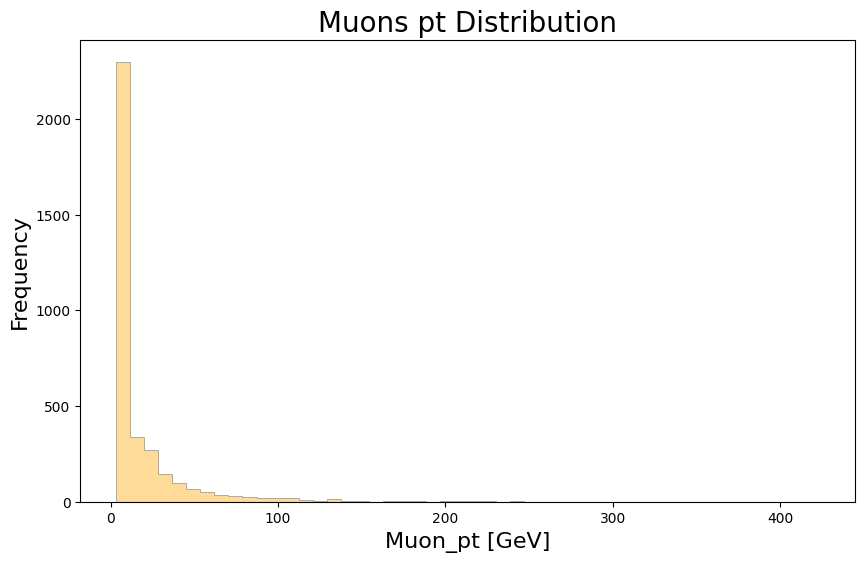

In [24]:
flatten_selected_muon_pt = np.hstack(selected_muon_pt)
plt.figure(figsize=(10,6))
plt.hist(flatten_selected_muon_pt, bins=50, color='orange', alpha=0.4, edgecolor='black', linewidth=0.5, histtype='stepfilled')
plt.title('Muons pt Distribution', fontsize=20)
plt.xlabel('Muon_pt [GeV]', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.grid(False)
plt.show()

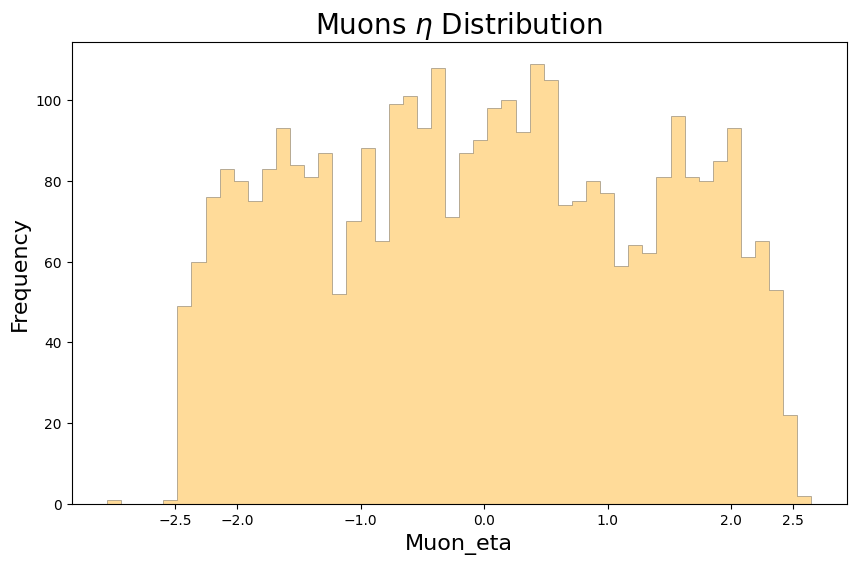

In [25]:
flatten_selected_muon_eta = np.hstack(selected_muon_eta)
plt.figure(figsize=(10,6))
plt.hist(flatten_selected_muon_eta, bins=50, color='orange', alpha=0.4, edgecolor='black', linewidth=0.5, histtype='stepfilled')
plt.title('Muons $\eta$ Distribution', fontsize=20)
plt.xlabel('Muon_eta', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks([-2.5, -2, -1, 0, 1, 2, 2.5]) 
plt.grid(False)
plt.show()

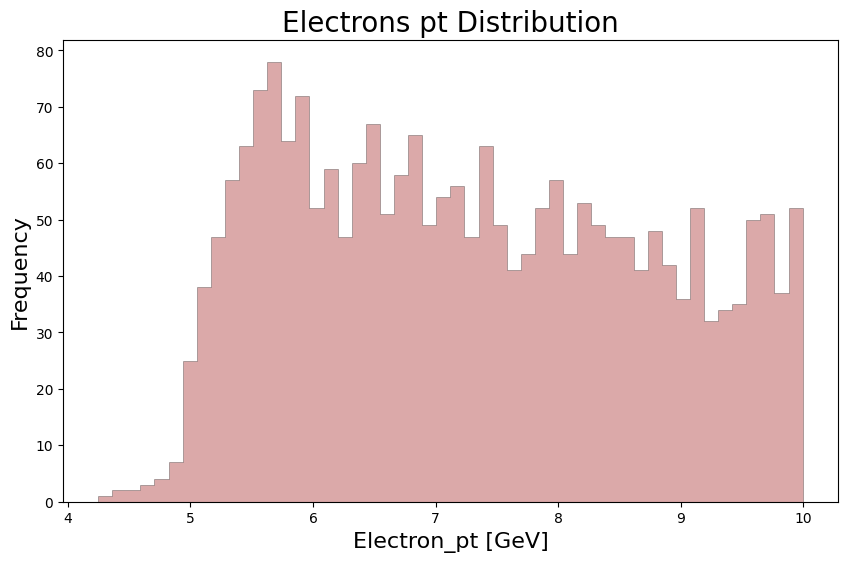

In [26]:
flatten_selected_electron_pt = np.hstack(selected_electron_pt)
plt.figure(figsize=(10,6))
plt.hist(flatten_selected_electron_pt, bins=50, color='brown', alpha=0.4, edgecolor='black', linewidth=0.5, histtype='stepfilled')
plt.title('Electrons pt Distribution', fontsize=20)
plt.xlabel('Electron_pt [GeV]', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.grid(False) 
plt.show()

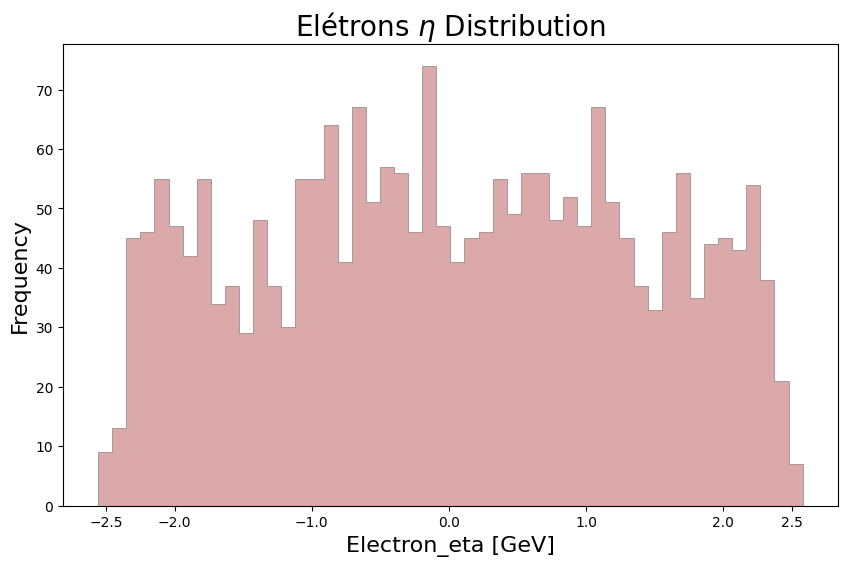

In [27]:
flatten_selected_electron_eta = np.hstack(selected_electron_eta)
plt.figure(figsize=(10,6))
plt.hist(flatten_selected_electron_eta, bins=50, color='brown', alpha=0.4, edgecolor='black', linewidth=0.5, histtype='stepfilled')
plt.title('Elétrons $\eta$ Distribution', fontsize=20)
plt.xlabel('Electron_eta [GeV]', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks([-2.5, -2, -1, 0, 1, 2, 2.5]) 
plt.grid(False) 
plt.show()

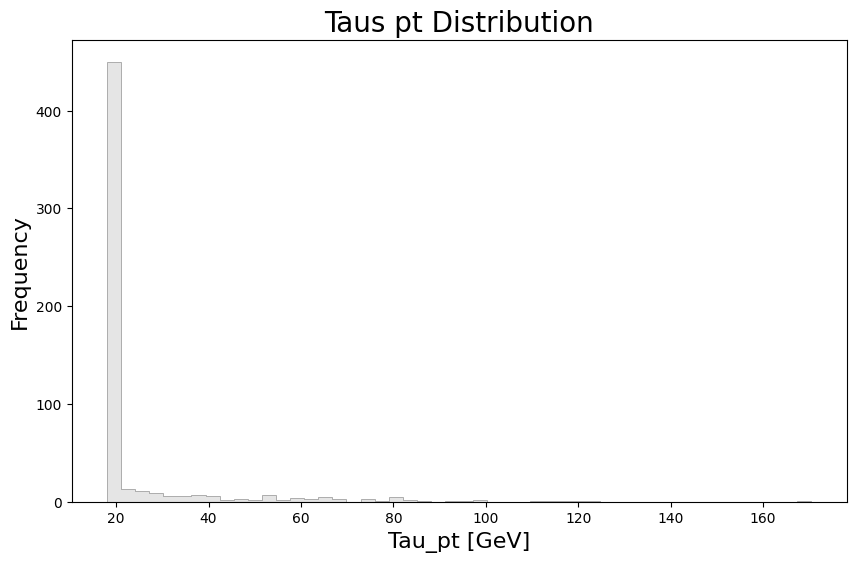

In [28]:
flatten_selected_tau_pt = np.hstack(selected_tau_pt)
plt.figure(figsize=(10,6))
plt.hist(flatten_selected_tau_pt, bins=50, color='silver', alpha=0.4, edgecolor='black', linewidth=0.5, histtype='stepfilled')
plt.title('Taus pt Distribution', fontsize=20)
plt.xlabel('Tau_pt [GeV]', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.grid(False) 
plt.show()

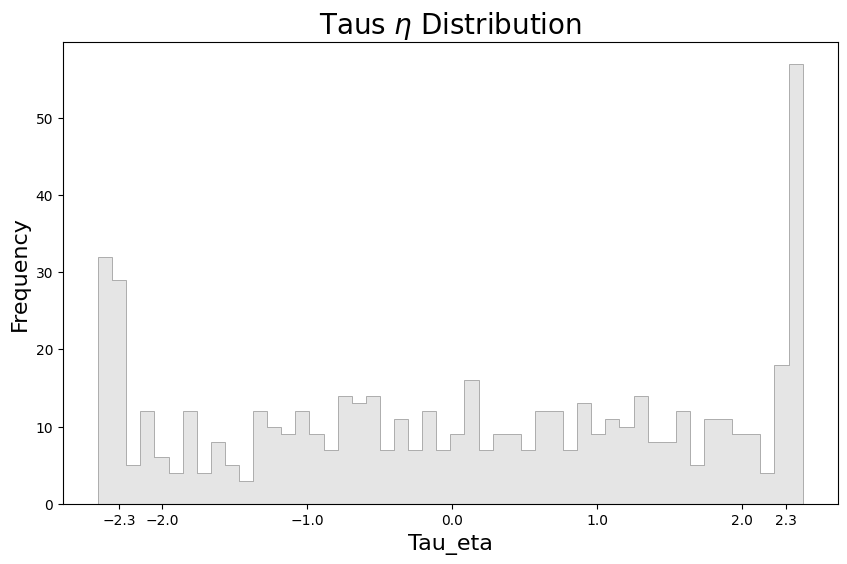

In [29]:
flatten_selected_tau_eta = np.hstack(selected_tau_eta)
plt.figure(figsize=(10,6))
plt.hist(flatten_selected_tau_eta, bins=50, color='silver', alpha=0.4, edgecolor='black', linewidth=0.5, histtype='stepfilled')
plt.title('Taus $\eta$ Distribution', fontsize=20)
plt.xlabel('Tau_eta', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks([-2.3, -2, -1, 0, 1, 2, 2.3]) 
plt.grid(False) 
plt.show()

In [30]:
# Create 4-vector objects for muons
muons = ak.zip(
    {"pt":  selected_muon_pt,           
     "eta": selected_muon_eta,         
     "phi": selected_muon_phi,        
     "mass": selected_muon_mass},     
    with_name="Momentum4D",                                             
)

# Create 4-vector objects for jets
jets = ak.zip(
    {"pt": selected_jet_pt,             
     "eta": selected_jet_eta,           
     "phi":  selected_jet_phi,           
     "mass": selected_jet_mass},        
    with_name="Momentum4D",                                             
)

# Create 4-vector objects for MET (missing transverse energy)
met = ak.zip(
    {"pt": selected_met_pt,                                       
     "eta": selected_met_eta,                                    
     "phi": selected_met_phi,                                     
     "mass": 0},                                                         
    with_name="Momentum4D",                                              
)


# Create 4-vector objects for electrons
electrons = ak.zip(
    {"pt": selected_electron_pt,                                       
     "eta": selected_electron_eta,                                    
     "phi": selected_electron_phi,                                     
     "mass": selected_electron_mass},                                 
    with_name="Momentum4D",                                              
)

# Create 4-vector objects for taus
taus = ak.zip(
    {"pt": selected_tau_pt,                                       
     "eta": selected_tau_eta,                                    
     "phi": selected_tau_phi,                                     
     "mass": selected_tau_mass},                                 
    with_name="Momentum4D",                                              
)

# Create 4-vector objects for photons
photons = ak.zip(
    {"pt": selected_photon_pt,                                       
     "eta": selected_photon_eta,                                    
     "phi": selected_photon_phi,                                     
     "mass": selected_photon_mass},                                 
    with_name="Momentum4D",                                              
)

# Create 4-vector object for the lead jet (first jet)
lead_jet = ak.zip(
    {"pt": selected_lead_jet_pt,
     "eta": selected_lead_jet_eta,
     "phi": selected_lead_jet_phi,
     "mass": selected_lead_jet_mass},
    with_name="Momentum4D",
)

 
lead_jet2 = ak.zip(
    {"pt": selected_lead_jet2_pt,
     "eta": selected_lead_jet2_eta,
     "phi": selected_lead_jet2_phi,
     "mass": selected_lead_jet2_mass},
    with_name="Momentum4D",
)
    
lead_jet3 = ak.zip(
    {"pt": selected_lead_jet3_pt,
     "eta": selected_lead_jet3_eta,
     "phi": selected_lead_jet3_phi,
     "mass": selected_lead_jet3_mass},
    with_name="Momentum4D",
)

lead_jet4 = ak.zip(
    {"pt": selected_lead_jet4_pt,
     "eta": selected_lead_jet4_eta,
     "phi": selected_lead_jet4_phi,
     "mass": selected_lead_jet4_mass},
    with_name="Momentum4D",
)

In [31]:
def save_file(dataset_name='default', IS_DATA=False):
    """
    Function to process and save real data or Monte Carlo in CSV file.
    Parameters:
    - dataset_name: Name of the dataset (string)
    - IS_DATA: Boolean that indicates whether it is real data (True) or Monte Carlo (False)
    """

    # Initialize variables
    N_gen = -999
    pileup = -999
    gw_pos = -999
    gw_neg = -999

    pileup_per_candidate = None

    tmpval_events = np.ones(len(selected_met_pt))
    tmpval = np.ones_like(selected_met_pt) 

    # Conditional for Monte Carlo or real data
    if not IS_DATA:
        # If it is Monte Carlo, calculate gen_weights and pileup 
        gen_weights_per_candidate = tmpval * gen_weights_selected
        pileup_per_candidate = tmpval * pileup_selected

        # Calculate gw_pos, gw_neg and N_gen
        gw_pos = ak.count(gen_weights[gen_weights > 0])
        gw_neg = ak.count(gen_weights[gen_weights < 0])
        N_gen = gw_pos - gw_neg
    else:
        # If real data, use placeholder values
        pileup_per_candidate = -999 * tmpval
        gen_weights_per_candidate = -999 * tmpval

    # Create the dictionary with the results
    mydict = {}
    mydict['pileup'] = pileup_per_candidate
    mydict['weight'] = gen_weights_per_candidate
    mydict['N_gen'] = N_gen * tmpval_events
    mydict['gw_pos'] = gw_pos * tmpval_events
    mydict['gw_neg'] = gw_neg * tmpval_events

    # Muons
    mydict['muon_pt'] = selected_muon_pt
    mydict['muon_eta'] = selected_muon_eta
    mydict['muon_phi'] = selected_muon_phi
    mydict['muon_mass'] = selected_muon_mass

    # MET
    mydict['met_pt'] = selected_met_pt
    mydict['met_phi'] = selected_met_phi
    mydict['met_eta'] = selected_met_eta

    #U 
    mydict['recoil_magnitude_u'] = selected_recoil_magnitude_u

    # CaloMET e MET PF
    mydict['calo_met_pt'] = selected_calo_met_pt
    mydict['met_pt_pf'] = selected_met_pt_pf
    mydict['met_phi_pf'] = selected_met_phi_pf

    # Electrons
    mydict['electron_pt'] = selected_electron_pt
    mydict['electron_eta'] = selected_electron_eta
    mydict['electron_phi'] = selected_electron_phi
    mydict['electron_mass'] = selected_electron_mass

    # Taus
    mydict['tau_pt'] = selected_tau_pt
    mydict['tau_eta'] = selected_tau_eta
    mydict['tau_phi'] = selected_tau_phi
    mydict['tau_mass'] = selected_tau_mass

    # Photons
    mydict['photon_pt'] = selected_photon_pt
    mydict['photon_eta'] = selected_photon_eta
    mydict['photon_phi'] = selected_photon_phi
    mydict['photon_mass'] = selected_photon_mass

    # Lead Jet 1
    mydict['lead_jet_pt'] = selected_lead_jet_pt
    mydict['lead_jet_eta'] = selected_lead_jet_eta
    mydict['lead_jet_phi'] = selected_lead_jet_phi
    mydict['lead_jet_mass'] = selected_lead_jet_mass
    mydict['lead_jet_btag_csvv2'] = selected_lead_jet_btag_csvv2
    mydict['lead_jet_ch_hef'] = selected_lead_jet_ch_hef

    # Lead Jet 2
    mydict['lead_jet2_pt'] = selected_lead_jet2_pt
    mydict['lead_jet2_eta'] = selected_lead_jet2_eta
    mydict['lead_jet2_phi'] = selected_lead_jet2_phi
    mydict['lead_jet2_mass'] = selected_lead_jet2_mass
    mydict['lead_jet2_btag_csvv2'] = selected_lead_jet2_btag_csvv2
    mydict['lead_jet2_ch_hef'] = selected_lead_jet2_ch_hef

    # Lead Jet 3
    mydict['lead_jet3_pt'] = selected_lead_jet3_pt
    mydict['lead_jet3_eta'] = selected_lead_jet3_eta
    mydict['lead_jet3_phi'] = selected_lead_jet3_phi
    mydict['lead_jet3_mass'] = selected_lead_jet3_mass
    mydict['lead_jet3_btag_csvv2'] = selected_lead_jet3_btag_csvv2
    mydict['lead_jet3_ch_hef'] = selected_lead_jet3_ch_hef

    # Lead Jet 4
    mydict['lead_jet4_pt'] = selected_lead_jet4_pt
    mydict['lead_jet4_eta'] = selected_lead_jet4_eta
    mydict['lead_jet4_phi'] = selected_lead_jet4_phi
    mydict['lead_jet4_mass'] = selected_lead_jet4_mass
    mydict['lead_jet4_btag_csvv2'] = selected_lead_jet4_btag_csvv2
    mydict['lead_jet4_ch_hef'] = selected_lead_jet4_ch_hef

    # Convert the dictionary into a DataFrame pandas
    df = pd.DataFrame.from_dict(mydict)

    # Save the DataFrame as a CSV file, using the name provided by the user
    df.to_csv(f"{dataset_name}.csv", index=False)

    print(f"Data processed and saved as {dataset_name}.csv")

In [32]:
# Call the function by passing the dataset name and whether it is data or Monte Carlo
save_file(dataset_name=dataset_name, IS_DATA=False)

Data processed and saved as FILE_LIST_WJetsToLNu_Pt-250To400.csv
